In [4]:
!wget 'https://www.kaggle.com/stevezhenghp/airbnb-price-prediction/download'

--2020-09-21 16:58:17--  https://www.kaggle.com/stevezhenghp/airbnb-price-prediction/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /account/login?returnUrl=%2Fstevezhenghp%2Fairbnb-price-prediction%3Fresource%3Ddownload%26downloadHash%3Dc56e1026ede621e2d37ad6b48aae1e97b74ff5d9adf38592ebcc713427594890&message=Welcome to Kaggle! Join our community of over 5 million data scientists. Find datasets and code as well as free access to compute on our platform.&titleType=dataset-downloads&showDatasetDownloadSkip=True [following]
--2020-09-21 16:58:18--  https://www.kaggle.com/account/login?returnUrl=%2Fstevezhenghp%2Fairbnb-price-prediction%3Fresource%3Ddownload%26downloadHash%3Dc56e1026ede621e2d37ad6b48aae1e97b74ff5d9adf38592ebcc713427594890&message=Welcome%20to%20Kaggle!%20Join%20our%20community%20of%20over%205%20million%20data%20scie

In [7]:
!unzip 'download.ZIP'

unzip:  cannot find or open download.ZIP, download.ZIP.zip or download.ZIP.ZIP.


In [11]:
import pandas as pd
import numpy as np
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*

     |████████████████████████████████| 81kB 2.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
df = pd.read_csv('train.csv', skiprows=[26044])
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [3]:
import matplotlib.pyplot as plt
import datetime as dt
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()
profile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
df['neighbourhood'].value_counts()[:10]

Williamsburg          2862
Bedford-Stuyvesant    2166
Bushwick              1601
Upper West Side       1396
Mid-Wilshire          1392
Harlem                1374
Hollywood             1321
Hell's Kitchen        1299
Venice                1222
Upper East Side       1206
Name: neighbourhood, dtype: int64

In [10]:
df_trainable = df.drop(['id', 'thumbnail_url', 'amenities','description', 'name',],axis = 1)
df_trainable['first_review'] = pd.to_datetime(df_trainable['first_review']).map(dt.datetime.toordinal)
df_trainable['host_since'] = pd.to_datetime(df_trainable['host_since']).map(dt.datetime.toordinal)
df_trainable['last_review'] = pd.to_datetime(df_trainable['last_review']).map(dt.datetime.toordinal)
df_trainable.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,736133,t,t,NaN,734588,f,736163,40.696524,-73.991617,Brooklyn Heights,2,100.0,11201,1.0,1.0
1,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,736546,t,f,100%,736499,t,736595,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0
2,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,736449,t,t,100%,736262,t,736586,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0
3,6.620073,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,1,t,t,NaN,735707,f,1,37.772004,-122.431619,Lower Haight,0,NaN,94117.0,2.0,2.0
4,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,735730,t,t,100%,735658,t,736351,38.925627,-77.034596,Columbia Heights,4,40.0,20009,0.0,1.0


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OrdinalEncoder
from xgboost import XGBRegressor

In [15]:
X = df_trainable.drop('log_price',axis=1)
y = df_trainable.log_price
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.25,random_state=42)

In [53]:
pipe = Pipeline([
                ('encode',OrdinalEncoder()),
                ('impute', SimpleImputer()),
                ('scale',MinMaxScaler()),
                ('model',XGBRegressor(random_state=41))
                ])
pipe.fit(X_train,y_train)

[19:31:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('encode',
                 OrdinalEncoder(cols=['property_type', 'room_type', 'bed_type',
                                      'cancellation_policy', 'city',
                                      'host_has_profile_pic',
                                      'host_identity_verified',
                                      'host_response_rate', 'instant_bookable',
                                      'neighbourhood', 'zipcode'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'property_type',
                                          'data_typ...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_

In [58]:
pipe['model'].feature_importances_

array([0.00608623, 0.4958058 , 0.05838008, 0.15398712, 0.        ,
       0.00285518, 0.00630752, 0.03256156, 0.01728237, 0.00230448,
       0.00624851, 0.00609875, 0.00383994, 0.        , 0.02063437,
       0.02013198, 0.02956945, 0.00816668, 0.00606964, 0.01574091,
       0.01844939, 0.08256295, 0.00691708], dtype=float32)

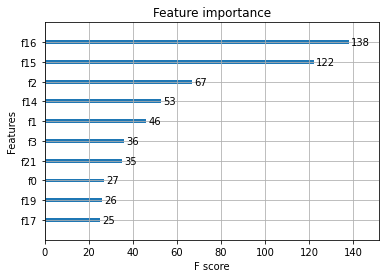

In [60]:
from xgboost import plot_importance
plot_importance(pipe['model'], max_num_features=10)

In [61]:
X_train.columns[[16,15,2,14,1,3,21,0,19,17]]

Index(['longitude', 'latitude', 'accommodates', 'last_review', 'room_type',
       'bathrooms', 'bedrooms', 'property_type', 'review_scores_rating',
       'neighbourhood'],
      dtype='object')

In [62]:
X_train.columns

Index(['property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'city', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [19]:
y_pred = pipe.predict(X_val)

In [20]:
from sklearn.metrics import mean_squared_error as MSE
MSE(y_pred,y_val)

0.1742244406651882

In [46]:
from sklearn.linear_model import LinearRegression
pipe = Pipeline([
                ('encode',OrdinalEncoder()),
                ('impute', SimpleImputer()),
                ('scale',MinMaxScaler()),
                ('model',LinearRegression())
                ])
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('encode',
                 OrdinalEncoder(cols=['property_type', 'room_type', 'bed_type',
                                      'cancellation_policy', 'city',
                                      'host_has_profile_pic',
                                      'host_identity_verified',
                                      'host_response_rate', 'instant_bookable',
                                      'neighbourhood', 'zipcode'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'property_type',
                                          'data_typ...
11426-1175    743
90670         744
11103-3233    745
Length: 745, dtype: int64}],
                                return_df=True, verbose=0)),
                ('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                       

In [52]:
features = X_train.columns
coefficients = np.absolute(pipe.named_steps['model'].coef_)
pd.Series(coefficients, features).sort_values(ascending=False)

bedrooms                  1.367795
accommodates              1.240016
room_type                 1.176037
bathrooms                 1.143393
beds                      0.605243
review_scores_rating      0.431506
city                      0.315962
zipcode                   0.258971
number_of_reviews         0.200656
neighbourhood             0.188770
last_review               0.123114
first_review              0.091657
host_has_profile_pic      0.088711
property_type             0.081967
bed_type                  0.074328
cancellation_policy       0.071850
latitude                  0.066835
longitude                 0.060861
instant_bookable          0.051066
cleaning_fee              0.029435
host_identity_verified    0.024835
host_since                0.024817
host_response_rate        0.017842
dtype: float64